In [5]:
import glob
import time
import numpy
import crowdsource
import regions
import numpy as np
from functools import cache
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy.modeling.fitting import LevMarLSQFitter
from astropy import wcs
from astropy import table
from astropy import stats
from astropy import units as u
from astropy.nddata import NDData
from astropy.io import fits
from scipy import ndimage
import requests
import requests.exceptions
import urllib3
import urllib3.exceptions
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import IntegratedGaussianPRF, extract_stars, EPSFStars, EPSFModel
try:
    # version >=1.7.0, doesn't work: the PSF is broken
    from photutils.psf import PSFPhotometry, IterativePSFPhotometry, SourceGrouper
except:
    # version 1.6.0, which works
    from photutils.psf import BasicPSFPhotometry as PSFPhotometry, IterativelySubtractedPSFPhotometry as IterativePSFPhotometry, DAOGroup as SourceGrouper
try:
    from photutils.background import MMMBackground, MADStdBackgroundRMS, MedianBackground, Background2D, LocalBackground
except:
    from photutils.background import MMMBackground, MADStdBackgroundRMS, MedianBackground, Background2D
    from photutils.background import MMMBackground as LocalBackground

from photutils.psf import EPSFBuilder
from photutils.psf import extract_stars

import warnings
from astropy.utils.exceptions import AstropyWarning, AstropyDeprecationWarning
warnings.simplefilter('ignore', category=AstropyWarning)
warnings.simplefilter('ignore', category=AstropyDeprecationWarning)

from crowdsource import crowdsource_base
from crowdsource.crowdsource_base import fit_im, psfmod

from astroquery.svo_fps import SvoFps

import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'

import os
print("Importing webbpsf", flush=True)
import webbpsf
from webbpsf.utils import to_griddedpsfmodel
import datetime


Importing webbpsf


In [6]:
from scipy.spatial import KDTree
import scipy
import scipy.ndimage

In [7]:
filt = filtername = 'f2550w'
#filt = filtername = 'f444w'

In [8]:
basepath = '/blue/adamginsburg/adamginsburg/jwst/brick/'

In [12]:
im1 = fits.open(f'{basepath}/F2550W/pipeline/jw02221-o002_t001_miri_f2550w_i2d.fits')
obsdate = im1[0].header['DATE-OBS']
ww = wcs.WCS(im1[1].header)

module = 'merged'
data = im1['SCI'].data[:400,400:800]
err = im1['ERR'].data[:400,400:800]

#im2 = fits.open(f'{basepath}/F2550W/pipeline/jw02221-o002_t001_miri_f2550w_i2d.fits')
#im2['SCI'].data = data
#im2['ERR'].data = err
#for ext in ('CON', 'WHT', 'VAR_POISSON', 'VAR_RNOISE', 'VAR_FLAT'):
#    del im2[ext]
#im2.writeto(f'{basepath}/analysis/MWE_example.fits', overwrite=True)

In [13]:
# basic check that the corner is OK.... (We need to use a corner for this test b/c the PSF grid is tuned for corners)
pl.imshow(data)

# PSF check

In [39]:
has_downloaded = False
ntries = 0
while not has_downloaded:
    try:
        miri = webbpsf.MIRI()
        miri.load_wss_opd_by_date(f'{obsdate}T00:00:00')
        miri.filter = filt
        if module in ('miria', 'mirib'):
            if 'F4' in filt.upper():
                miri.detector = f'{module.upper()}5' # I think miriA5 must be the "long" detector?
            else:
                miri.detector = f'{module.upper()}1' #TODO: figure out a way to use all 4?
            grid = miri.psf_grid(num_psfs=16, all_detectors=False, verbose=True, save=True)
        else:
            grid = miri.psf_grid(num_psfs=16, all_detectors=True, verbose=True, save=True)
        has_downloaded = True
    except (urllib3.exceptions.ReadTimeoutError, requests.exceptions.ReadTimeout, requests.HTTPError) as ex:
        print(f"Failed to build PSF: {ex}", flush=True)
        raise
    except Exception as ex:
        print(ex, flush=True)
        if ntries > 10:
            # avoid infinite loops
            raise ValueError("Failed to download PSF, probably because of an error listed above")
        else:
            raise
            continue


MAST OPD query around UTC: 2023-04-15T00:00:00.000
                        MJD: 60049.0

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2023041402-NRCA3_FP1-1.fits
	Date (MJD):	 60047.9910
	Delta time:	 -1.0090 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2023041602-NRCA3_FP1-1.fits
	Date (MJD):	 60049.7619
	Delta time:	 0.7619 days
User requested choosing OPD time closest in time to 2023-04-15T00:00:00.000, which is R2023041602-NRCA3_FP1-1.fits, delta time 0.762 days
Importing and format-converting OPD from /red/adamginsburg/repos/webbpsf/data/MAST_JWST_WSS_OPDs/R2023041602-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point

Running instrument: MIRI, filter: F2550W
  Running detector: MIRIFULONG
    Position 1/16: (0, 0) pixels


/red/adamginsburg/repos/webbpsf/webbpsf/opds.py:1759: UserWarning: For (V2,V3) = [-6.36389848 -7.26853851] arcmin, Field point -6.3638984816102235 arcmin, -0.5632056 arcmin not within valid region for field dependence model of OTE WFE for MIRI: -8.254199999999999 arcmin--6.21738 arcmin, -2.557224 arcmin--0.5632056 arcmin.  Clipping to closest available valid location, 0.031744109903437345 arcmin away from the requested coordinates.
  warnings.warn(warning_message)


    Position 1/16 centroid: (201.4960746072375, 201.55158176338998)
    Position 2/16: (0, 341) pixels
    Position 2/16 centroid: (201.4879040605451, 201.47900831114072)
    Position 3/16: (0, 682) pixels
    Position 3/16 centroid: (201.5241986246422, 201.52055786168066)
    Position 4/16: (0, 1023) pixels


/red/adamginsburg/repos/webbpsf/webbpsf/opds.py:1759: UserWarning: For (V2,V3) = [-6.21257653 -5.39972458] arcmin, Field point -6.21738 arcmin, -2.4002754231217454 arcmin not within valid region for field dependence model of OTE WFE for MIRI: -8.254199999999999 arcmin--6.21738 arcmin, -2.557224 arcmin--0.5632056 arcmin.  Clipping to closest available valid location, 0.00480347054204433 arcmin away from the requested coordinates.
  warnings.warn(warning_message)


    Position 4/16 centroid: (201.48265277738807, 201.53094921091014)
    Position 5/16: (341, 0) pixels
    Position 5/16 centroid: (201.48513886053533, 201.53733644925367)
    Position 6/16: (341, 341) pixels
    Position 6/16 centroid: (201.5231018977502, 201.55276769356837)
    Position 7/16: (341, 682) pixels
    Position 7/16 centroid: (201.51876768282526, 201.5212707383575)
    Position 8/16: (341, 1023) pixels
    Position 8/16 centroid: (201.4796628564171, 201.5340410517751)
    Position 9/16: (682, 0) pixels
    Position 9/16 centroid: (201.4972535696582, 201.51174242008716)
    Position 10/16: (682, 341) pixels
    Position 10/16 centroid: (201.489532153346, 201.53990344792052)
    Position 11/16: (682, 682) pixels
    Position 11/16 centroid: (201.49052150227723, 201.49510499441962)
    Position 12/16: (682, 1023) pixels
    Position 12/16 centroid: (201.51290096701436, 201.52098867453375)
    Position 13/16: (1023, 0) pixels
    Position 13/16 centroid: (201.5569787731733, 

/red/adamginsburg/repos/webbpsf/webbpsf/opds.py:1759: UserWarning: For (V2,V3) = [-6.36389848 -7.26853851] arcmin, Field point -6.3638984816102235 arcmin, -0.5632056 arcmin not within valid region for field dependence model of OTE WFE for MIRI: -8.254199999999999 arcmin--6.21738 arcmin, -2.557224 arcmin--0.5632056 arcmin.  Clipping to closest available valid location, 0.031744109903437345 arcmin away from the requested coordinates.
  warnings.warn(warning_message)


    Position 1/16 centroid: (201.4960746072375, 201.55158176338998)
    Position 2/16: (0, 341) pixels
    Position 2/16 centroid: (201.4879040605451, 201.47900831114072)
    Position 3/16: (0, 682) pixels
    Position 3/16 centroid: (201.5241986246422, 201.52055786168066)
    Position 4/16: (0, 1023) pixels


/red/adamginsburg/repos/webbpsf/webbpsf/opds.py:1759: UserWarning: For (V2,V3) = [-6.21257653 -5.39972458] arcmin, Field point -6.21738 arcmin, -2.4002754231217454 arcmin not within valid region for field dependence model of OTE WFE for MIRI: -8.254199999999999 arcmin--6.21738 arcmin, -2.557224 arcmin--0.5632056 arcmin.  Clipping to closest available valid location, 0.00480347054204433 arcmin away from the requested coordinates.
  warnings.warn(warning_message)


    Position 4/16 centroid: (201.48265277738807, 201.53094921091014)
    Position 5/16: (341, 0) pixels
    Position 5/16 centroid: (201.48513886053533, 201.53733644925367)
    Position 6/16: (341, 341) pixels
    Position 6/16 centroid: (201.5231018977502, 201.55276769356837)
    Position 7/16: (341, 682) pixels
    Position 7/16 centroid: (201.51876768282526, 201.5212707383575)
    Position 8/16: (341, 1023) pixels
    Position 8/16 centroid: (201.4796628564171, 201.5340410517751)
    Position 9/16: (682, 0) pixels
    Position 9/16 centroid: (201.4972535696582, 201.51174242008716)
    Position 10/16: (682, 341) pixels
    Position 10/16 centroid: (201.489532153346, 201.53990344792052)
    Position 11/16: (682, 682) pixels
    Position 11/16 centroid: (201.49052150227723, 201.49510499441962)
    Position 12/16: (682, 1023) pixels
    Position 12/16 centroid: (201.51290096701436, 201.52098867453375)
    Position 13/16: (1023, 0) pixels
    Position 13/16 centroid: (201.5569787731733, 

/red/adamginsburg/repos/webbpsf/webbpsf/opds.py:1759: UserWarning: For (V2,V3) = [-6.36389848 -7.26853851] arcmin, Field point -6.3638984816102235 arcmin, -0.5632056 arcmin not within valid region for field dependence model of OTE WFE for MIRI: -8.254199999999999 arcmin--6.21738 arcmin, -2.557224 arcmin--0.5632056 arcmin.  Clipping to closest available valid location, 0.031744109903437345 arcmin away from the requested coordinates.
  warnings.warn(warning_message)


    Position 1/16 centroid: (201.4960746072375, 201.55158176338998)
    Position 2/16: (0, 341) pixels
    Position 2/16 centroid: (201.4879040605451, 201.47900831114072)
    Position 3/16: (0, 682) pixels
    Position 3/16 centroid: (201.5241986246422, 201.52055786168066)
    Position 4/16: (0, 1023) pixels


/red/adamginsburg/repos/webbpsf/webbpsf/opds.py:1759: UserWarning: For (V2,V3) = [-6.21257653 -5.39972458] arcmin, Field point -6.21738 arcmin, -2.4002754231217454 arcmin not within valid region for field dependence model of OTE WFE for MIRI: -8.254199999999999 arcmin--6.21738 arcmin, -2.557224 arcmin--0.5632056 arcmin.  Clipping to closest available valid location, 0.00480347054204433 arcmin away from the requested coordinates.
  warnings.warn(warning_message)


    Position 4/16 centroid: (201.48265277738807, 201.53094921091014)
    Position 5/16: (341, 0) pixels
    Position 5/16 centroid: (201.48513886053533, 201.53733644925367)
    Position 6/16: (341, 341) pixels
    Position 6/16 centroid: (201.5231018977502, 201.55276769356837)
    Position 7/16: (341, 682) pixels
    Position 7/16 centroid: (201.51876768282526, 201.5212707383575)
    Position 8/16: (341, 1023) pixels
    Position 8/16 centroid: (201.4796628564171, 201.5340410517751)
    Position 9/16: (682, 0) pixels
    Position 9/16 centroid: (201.4972535696582, 201.51174242008716)
    Position 10/16: (682, 341) pixels
    Position 10/16 centroid: (201.489532153346, 201.53990344792052)
    Position 11/16: (682, 682) pixels
    Position 11/16 centroid: (201.49052150227723, 201.49510499441962)
    Position 12/16: (682, 1023) pixels
    Position 12/16 centroid: (201.51290096701436, 201.52098867453375)
    Position 13/16: (1023, 0) pixels
    Position 13/16 centroid: (201.5569787731733, 

In [40]:
dao_psf_model = grid

# Load data / errors

In [16]:
# crowdsource uses inverse-sigma, not inverse-variance
weight = err**-1
maxweight = np.percentile(weight[np.isfinite(weight)], 95)
minweight = np.percentile(weight[np.isfinite(weight)], 5)
badweight =  np.percentile(weight[np.isfinite(weight)], 1)
weight[err < 1e-5] = 0
#weight[(err == 0) | (wht == 0)] = np.nanmedian(weight)
weight[np.isnan(weight)] = 0
bad = np.isnan(weight) | (data == 0) | np.isnan(data) | (weight == 0) | (err == 0) | (data < 1e-5)

weight[weight > maxweight] = maxweight
weight[weight < minweight] = minweight
# it seems that crowdsource doesn't like zero weights
# may have caused broked f466n? weight[bad] = badweight
weight[bad] = minweight
# crowdsource explicitly handles weight=0, so this _should_ work.
weight[bad] = 0

# Expand bad pixel zones for dq
bad_for_dq = ndimage.binary_dilation(bad, iterations=2)
print(f"Total bad pixels = {bad.sum()}, total bad for dq={bad_for_dq.sum()}")

mask = bad

mask = scipy.ndimage.binary_dilation(scipy.ndimage.binary_erosion(mask, iterations=1), iterations=1)
mask = scipy.ndimage.binary_erosion(scipy.ndimage.binary_dilation(mask, iterations=1), iterations=1)

Total bad pixels = 2011, total bad for dq=3301


# Start tests

In [41]:
print(f"Starting filter {filtername}", flush=True)
fwhm_tbl = Table.read(f'{basepath}/reduction/fwhm_table.ecsv')
row = fwhm_tbl[fwhm_tbl['Filter'] == filtername.upper()]
fwhm = fwhm_arcsec = float(row['PSF FWHM (arcsec)'][0])
fwhm_pix = float(row['PSF FWHM (pixel)'][0])
fwhm_pix

Starting filter f2550w


7.3

In [42]:
grouper = SourceGrouper(2 * fwhm_pix)
mmm_bkg = MMMBackground()

filtered_errest = stats.sigma_clipped_stats(data, stdfunc='mad_std')
print(f'Error estimate for DAO from stats.: {filtered_errest}', flush=True)
filtered_errest = np.nanmedian(err)
print(f'Error estimate for DAO from median(err): {filtered_errest}', flush=True)

Error estimate for DAO from stats.: (2098.109, 2057.8027, 217.66292)
Error estimate for DAO from median(err): 0.967724621295929


In [43]:
daofind_tuned = DAOStarFinder(threshold=5 * filtered_errest,
                              fwhm=fwhm_pix, roundhi=0.3, roundlo=-0.3,
                              sharplo=0.30, sharphi=1.40,
                              exclude_border=True
                             )
print("Finding stars with daofind_tuned", flush=True)
finstars = daofind_tuned(np.nan_to_num(data), mask=mask)

print(f"Found {len(finstars)} with daofind_tuned", flush=True)
# for diagnostic plotting convenience
finstars['x'] = finstars['xcentroid']
finstars['y'] = finstars['ycentroid']

Finding stars with daofind_tuned
Found 63 with daofind_tuned


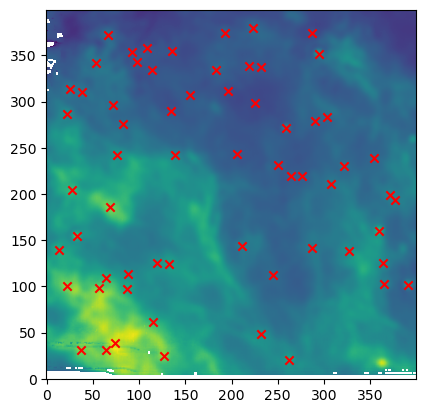

In [44]:
pl.imshow(data)
pl.scatter(finstars['x'], finstars['y'], color='r', marker='x');

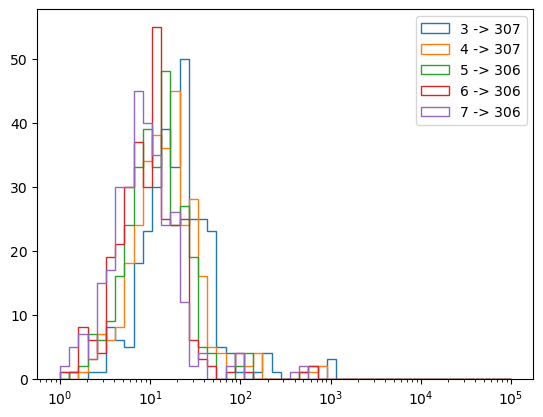

In [45]:
for threshold in (3,4,5,6,7):
    daofind_test = DAOStarFinder(threshold=threshold * filtered_errest,
                                  fwhm=fwhm_pix, roundhi=1.0, roundlo=-1.0,
                                  sharplo=0.30, sharphi=1.40,
                                  exclude_border=True
                                 )
    finstars_test = daofind_test(np.nan_to_num(data), mask=mask)
    pl.hist(finstars_test['flux'], bins=np.logspace(0,5), histtype='step', label=f'{threshold} -> {len(finstars_test)}')
pl.xscale('log');
pl.legend(loc='best');

In [46]:
for fwhm in (0.5*fwhm_pix, 1*fwhm_pix, 1.5*fwhm_pix):
    daofind_test = DAOStarFinder(threshold=threshold * filtered_errest,
                                  fwhm=fwhm, roundhi=1.0, roundlo=-1.0,
                                  sharplo=0.30, sharphi=1.40,
                                  exclude_border=True
                                 )
    finstars_test = daofind_test(np.nan_to_num(data))
    pl.hist(finstars_test['flux'], bins=np.logspace(0,5), histtype='step', label=fwhm)
pl.xscale('log');
pl.legend(loc='best');

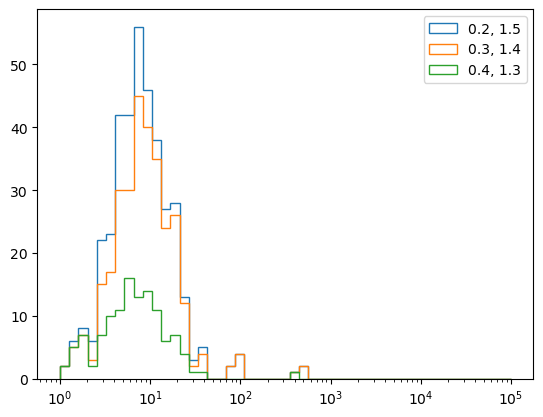

In [47]:
for sharplo, sharphi in ((0.2, 1.5), (0.3, 1.4), (0.4, 1.3)):
    daofind_test = DAOStarFinder(threshold=threshold * filtered_errest,
                                  fwhm=fwhm_pix, roundhi=1.0, roundlo=-1.0,
                                  sharplo=sharplo, sharphi=sharphi,
                                  exclude_border=True
                                 )
    finstars_test = daofind_test(np.nan_to_num(data))
    pl.hist(finstars_test['flux'], bins=np.logspace(0,5), histtype='step', label=f'{sharplo}, {sharphi}')
pl.xscale('log');
pl.legend(loc='best');

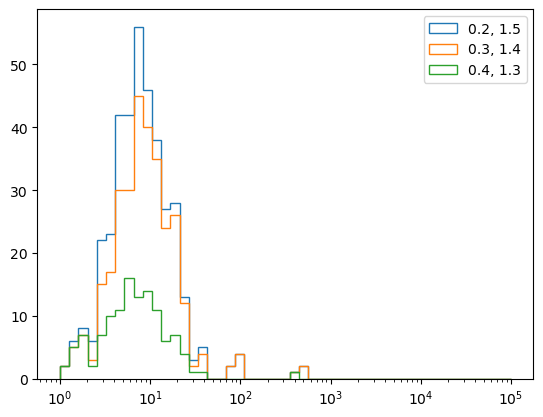

In [48]:
for sharplo, sharphi in ((0.2, 1.5), (0.3, 1.4), (0.4, 1.3)):
    daofind_test = DAOStarFinder(threshold=threshold * filtered_errest,
                                  fwhm=fwhm_pix, roundhi=1.0, roundlo=-1.0,
                                  sharplo=sharplo, sharphi=sharphi,
                                  exclude_border=True
                                 )
    finstars_test = daofind_test(np.nan_to_num(data))
    pl.hist(finstars_test['flux'], bins=np.logspace(0,5), histtype='step', label=f'{sharplo}, {sharphi}')
pl.xscale('log');
pl.legend(loc='best');

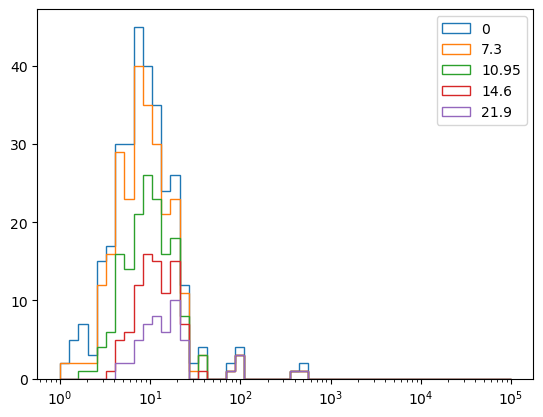

In [49]:
for min_separation in (0, fwhm_pix, 1.5*fwhm_pix, 2*fwhm_pix, 3*fwhm_pix):
    daofind_test = DAOStarFinder(threshold=threshold * filtered_errest,
                                  fwhm=fwhm_pix, roundhi=1.0, roundlo=-1.0,
                                  sharplo=0.3, sharphi=1.4,
                                  exclude_border=True,
                                 min_separation=min_separation,
                                 )
    finstars_test = daofind_test(np.nan_to_num(data))
    pl.hist(finstars_test['flux'], bins=np.logspace(0,5), histtype='step', label=min_separation)
pl.xscale('log');
pl.legend(loc='best');

In [50]:
data.shape, data.size, mask.sum(), bad.sum()

((400, 400), 160000, 1489, 2011)

In [53]:
dao_psf_model

[<GriddedPSFModel(flux=1., x_0=0., y_0=0.)>,
 <GriddedPSFModel(flux=1., x_0=0., y_0=0.)>,
 <GriddedPSFModel(flux=1., x_0=0., y_0=0.)>]

# BASIC

In [54]:
phot = PSFPhotometry(finder=daofind_tuned,#finder_maker(),
                     #grouper=grouper,
                     #localbkg_estimator=None, # must be none or it un-saturates pixels
                     localbkg_estimator=LocalBackground(5, 15),
                     psf_model=dao_psf_model[0],
                     fitter=LevMarLSQFitter(),
                     fit_shape=(5, 5),
                     aperture_radius=2*fwhm_pix,
                     progress_bar=True,
                     xy_bounds=1,
                    )

print("About to do BASIC photometry....")
t0 = time.time()

# mask causes the error 'ValueError: For one or more sources, the number of data points available to fit is less than the number of fit parameters. This could be due to a source(s) near the edge of the detector or if it has few unmasked pixels. Please check the input mask or source positions.'
# for f444w.  This is certainly a bug; daofind shouldn't put stars there.
result = phot(np.nan_to_num(data), mask=mask)
print(f"Done with BASIC photometry.  len(result)={len(result)} dt={time.time() - t0}")

About to do BASIC photometry....


Fit source/group:   0%|          | 0/63 [00:00<?, ?it/s]

Done with BASIC photometry.  len(result)=63 dt=1.3312606811523438


In [85]:
grouper = SourceGrouper(2 * fwhm_pix)
groups = grouper(finstars['x'], finstars['y'])
np.unique(groups).size, len(finstars), np.bincount(groups).max()

(54, 63, 2)

In [86]:
residual = phot.make_residual_image(data, (71, 71), include_localbkg=False)

Add model sources:   0%|          | 0/63 [00:00<?, ?it/s]

In [87]:
model = phot.make_model_image(data.shape, (71, 71), include_localbkg=False)

Add model sources:   0%|          | 0/63 [00:00<?, ?it/s]

In [88]:
model_withbg = phot.make_model_image(data.shape, (71, 71), include_localbkg=True)

Add model sources:   0%|          | 0/63 [00:00<?, ?it/s]

In [73]:
phot_biggerfootprint = PSFPhotometry(finder=daofind_tuned,#finder_maker(),
                     #grouper=grouper,
                     #localbkg_estimator=None, # must be none or it un-saturates pixels
                     localbkg_estimator=LocalBackground(5, 15),
                     psf_model=dao_psf_model[0],
                     fitter=LevMarLSQFitter(),
                     fit_shape=(7, 7),
                     aperture_radius=2.2*fwhm_pix,
                     progress_bar=True,
                                     xy_bounds=1,
                    )

print("About to do BASIC photometry....")
t0 = time.time()
try:
    result_biggerfootprint = phot_biggerfootprint(np.nan_to_num(data), mask=mask)
except Exception as ex:
    print(ex)
    result_biggerfootprint = phot_biggerfootprint(np.nan_to_num(data))
model_biggerfootprint = phot_biggerfootprint.make_model_image(data.shape, (31, 31), include_localbkg=False)
residual_biggerfootprint = data - model_biggerfootprint
print(f"Done with BASIC photometry.  len(result)={len(result)} dt={time.time() - t0}")


About to do BASIC photometry....


Fit source/group:   0%|          | 0/63 [00:00<?, ?it/s]

Add model sources:   0%|          | 0/63 [00:00<?, ?it/s]

Done with BASIC photometry.  len(result)=63 dt=1.68522047996521


In [74]:
dist, ind = KDTree(np.array([result['x_fit'], result['y_fit']]).T).query(np.array([result['x_fit'], result['y_fit']]).T, 2) 
close_neighbor = ind[:,1][dist[:,1] < 1]

#dist, ind = KDTree(np.array([result_g['x_fit'], result_g['y_fit']]).T).query(np.array([result_g['x_fit'], result_g['y_fit']]).T, 2) 
#close_neighbor_g = ind[:,1][dist[:,1] < 1]

dist, ind = KDTree(np.array([result_biggerfootprint['x_fit'], result_biggerfootprint['y_fit']]).T).query(np.array([result_biggerfootprint['x_fit'], result_biggerfootprint['y_fit']]).T, 2) 
close_neighbor_biggerfootprint = ind[:,1][dist[:,1] < 1]

len(close_neighbor), len(close_neighbor_biggerfootprint)#  len(close_neighbor_g),

(0, 0)

In [75]:
close_neighbor_biggerfootprint.shape

(0,)

### Default

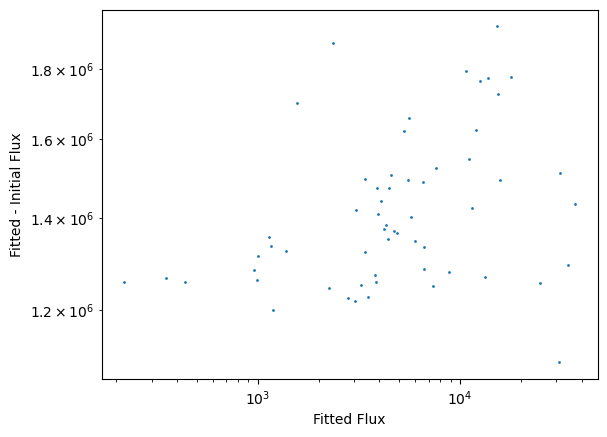

In [76]:
pl.scatter(result['flux_fit'], np.abs(result['flux_fit'] - result['flux_init']), s=1)
pl.scatter(result['flux_fit'][close_neighbor], np.abs(result['flux_fit'] - result['flux_init'])[close_neighbor], s=1)
pl.loglog()
pl.xlabel("Fitted Flux")
pl.ylabel("Fitted - Initial Flux");

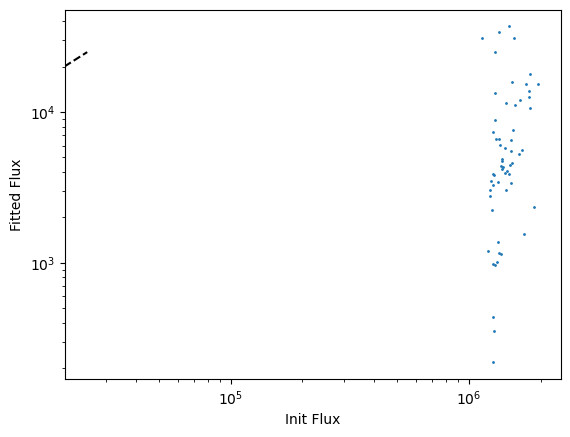

In [77]:
pl.scatter(result['flux_init'], result['flux_fit'] , s=1)
pl.scatter(result['flux_init'][close_neighbor], result['flux_fit'][close_neighbor] , s=1)
pl.xlabel("Init Flux")
pl.ylabel("Fitted Flux")
pl.loglog()
pl.plot([0,25000],[0,25000], 'k--');

In [78]:
pl.scatter(result['flux_fit'], result['x_fit'] - result['x_init'], s=1)
pl.scatter(result['flux_fit'][close_neighbor], (result['x_fit'] - result['x_init'])[close_neighbor], s=1)
pl.xlabel("Fitted Flux")
pl.ylabel("Fitted - Initial X value")
pl.ylim(-5,5)
pl.semilogx();

### Grouped

### Bigger Footprint

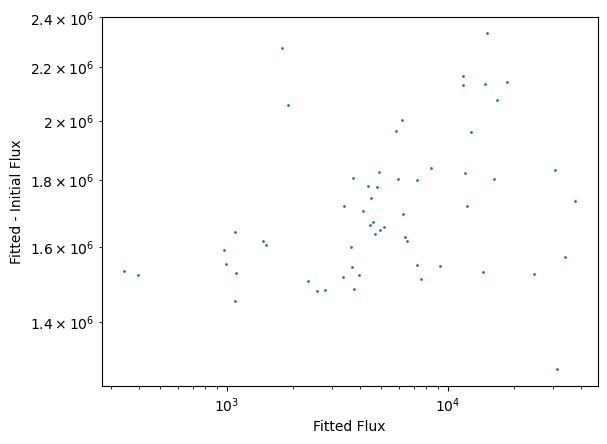

In [79]:
pl.scatter(result_biggerfootprint['flux_fit'], np.abs(result_biggerfootprint['flux_fit'] - result_biggerfootprint['flux_init']), s=1)
pl.scatter(result_biggerfootprint['flux_fit'][close_neighbor_biggerfootprint], np.abs(result_biggerfootprint['flux_fit'] - result_biggerfootprint['flux_init'])[close_neighbor_biggerfootprint], s=1)
pl.loglog()
pl.xlabel("Fitted Flux")
pl.ylabel("Fitted - Initial Flux");

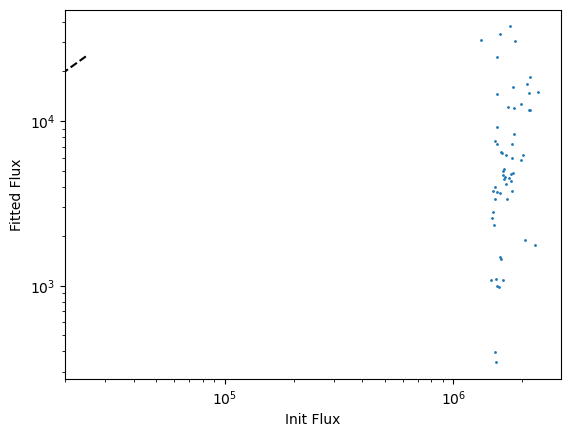

In [80]:
pl.scatter(result_biggerfootprint['flux_init'], result_biggerfootprint['flux_fit'] , s=1)
pl.scatter(result_biggerfootprint['flux_init'][close_neighbor_biggerfootprint], result_biggerfootprint['flux_fit'][close_neighbor_biggerfootprint] , s=1)
pl.xlabel("Init Flux")
pl.ylabel("Fitted Flux")
pl.loglog()
pl.plot([0,25000],[0,25000], 'k--');

In [81]:
pl.scatter(result_biggerfootprint['flux_fit'], result_biggerfootprint['x_fit'] - result_biggerfootprint['x_init'], s=1)
pl.scatter(result_biggerfootprint['flux_fit'][close_neighbor_biggerfootprint], (result_biggerfootprint['x_fit'] - result_biggerfootprint['x_init'])[close_neighbor_biggerfootprint], s=1)
pl.xlabel("Fitted Flux")
pl.ylabel("Fitted - Initial X value")
pl.semilogx();

### Histograms

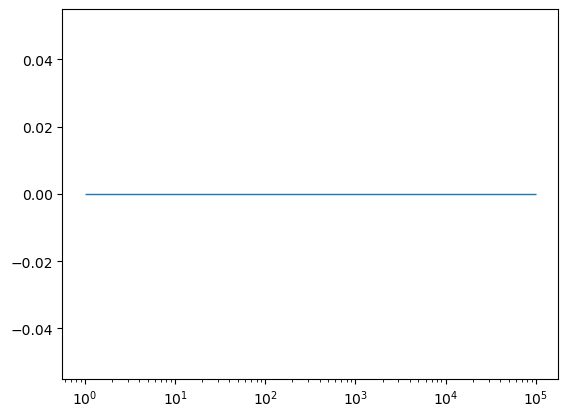

In [82]:
pl.hist(result['flux_init'], bins=np.logspace(0,5), histtype='step')
#pl.hist(result_g['flux_init'], bins=np.logspace(0,5), histtype='step')
pl.xscale('log');

In [83]:
pl.hist(result['flux_fit'], bins=np.logspace(0,5), histtype='step', label='default')
#pl.hist(result_g['flux_fit'], bins=np.logspace(0,5), histtype='step', label='group')
pl.hist(result_biggerfootprint['flux_fit'], bins=np.logspace(0,5), histtype='step', label='biggerfootprint')
pl.xscale('log');
pl.legend(loc='best');

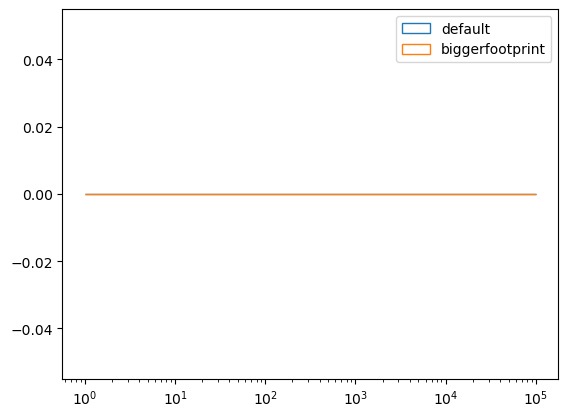

In [84]:
pl.hist(result['flux_fit'][close_neighbor], bins=np.logspace(0,5), histtype='step', label='default')
#pl.hist(result_g['flux_fit'][close_neighbor_g], bins=np.logspace(0,5), histtype='step', label='group')
pl.hist(result_biggerfootprint['flux_fit'][close_neighbor_biggerfootprint], bins=np.logspace(0,5), histtype='step', label='biggerfootprint')
pl.xscale('log');
pl.legend(loc='best');

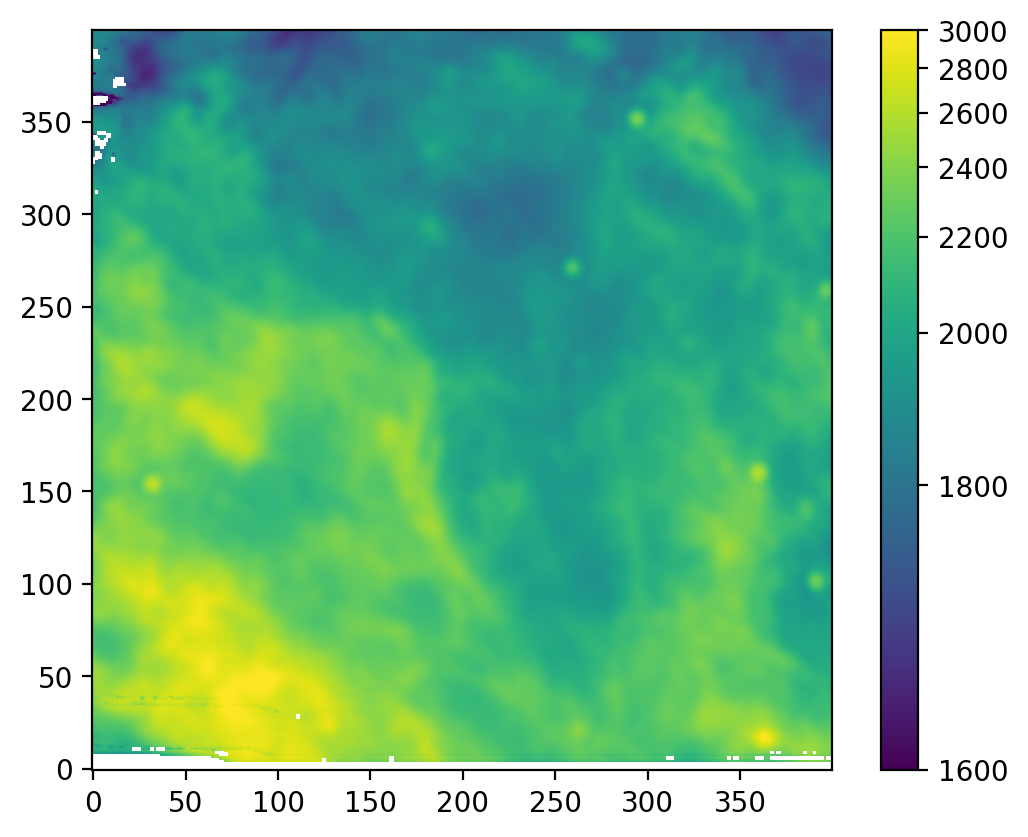

In [89]:
pl.figure(dpi=200)
pl.imshow(data, norm=simple_norm(data, min_cut=1600, max_cut=3000, stretch='asinh'))
pl.colorbar();

/scratch/local/39765574/ipykernel_647341/868644761.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  pl.scatter((result['x_fit'])[s1], (result['y_fit'])[s1], marker='x', color='red', cmap='jet',
/scratch/local/39765574/ipykernel_647341/868644761.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  pl.scatter((result['x_fit'])[s2], (result['y_fit'])[s2], marker='x', color='blue', cmap='jet',


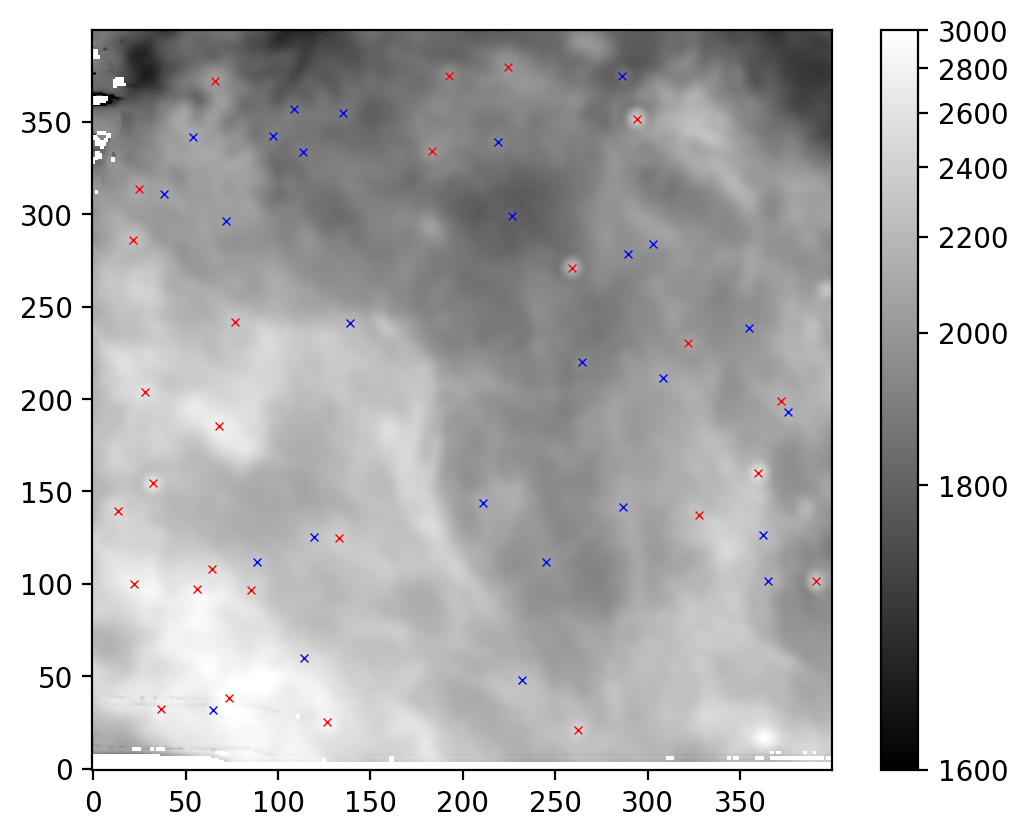

In [90]:
pl.figure(dpi=200)
pl.imshow(data, norm=simple_norm(data, min_cut=1600, max_cut=3000, stretch='asinh'), cmap='gray')
pl.colorbar();
s1 = result['flux_fit'] > 5000
pl.scatter((result['x_fit'])[s1], (result['y_fit'])[s1], marker='x', color='red', cmap='jet',
           linewidths=0.5, s=8)
s2 = (result['flux_fit'] < 5000) & (result['flux_fit'] > 1000)
pl.scatter((result['x_fit'])[s2], (result['y_fit'])[s2], marker='x', color='blue', cmap='jet',
           linewidths=0.5, s=8);

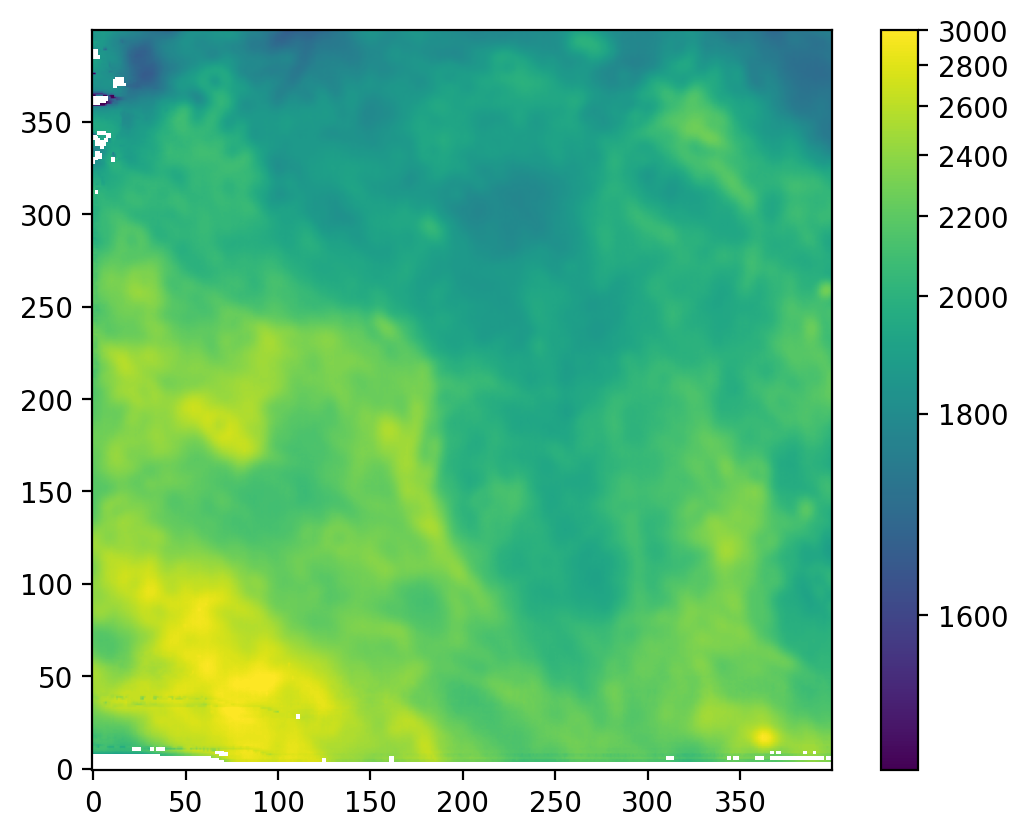

In [91]:
pl.figure(dpi=200)
pl.imshow(residual, norm=simple_norm(residual, min_cut=1500, max_cut=3000, stretch='asinh'))
pl.colorbar();

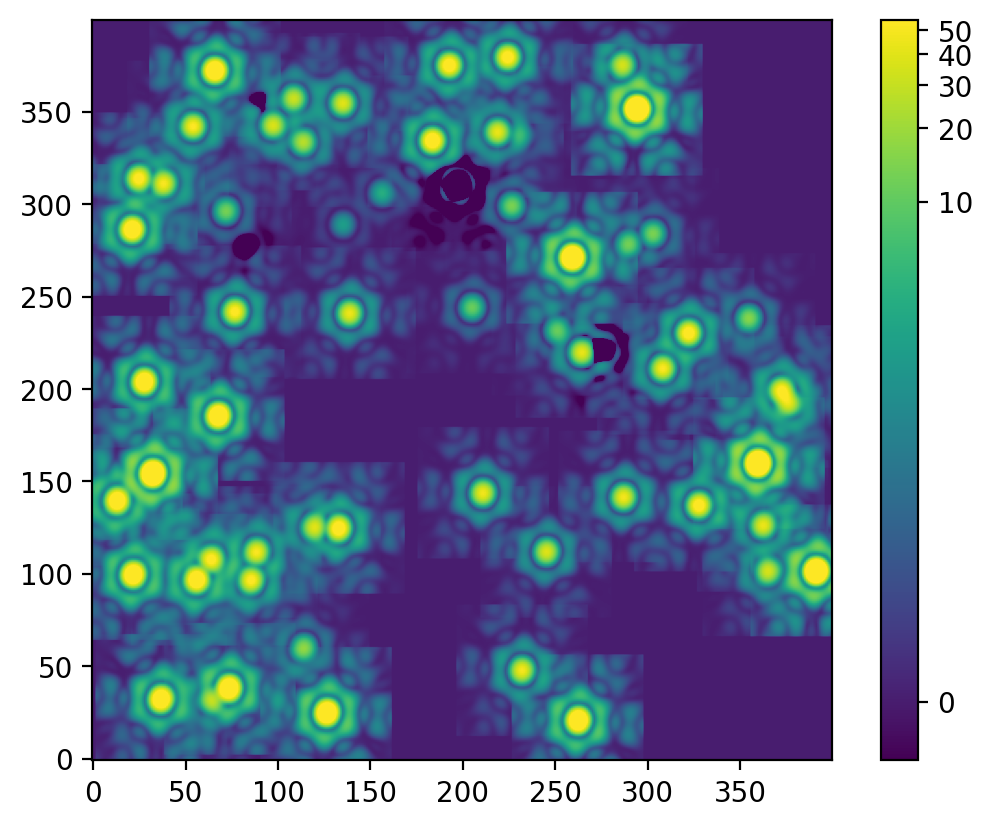

In [92]:
pl.figure(dpi=200)
pl.imshow(model, norm=simple_norm(model, min_percent=1, max_percent=99, stretch='log'))
pl.colorbar();

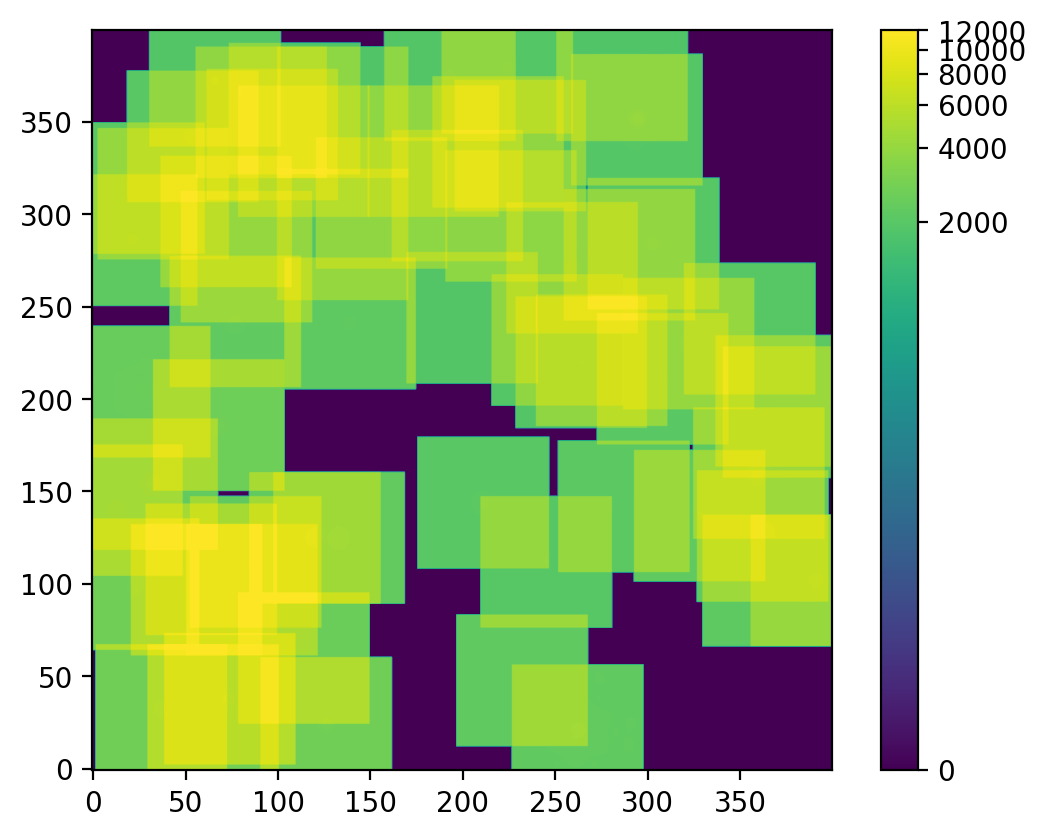

In [94]:
pl.figure(dpi=200)
pl.imshow(model_withbg, norm=simple_norm(model_withbg, min_percent=1, max_percent=99, stretch='log'))
pl.colorbar();

In [95]:
xl,xu,yl,yu = 100,300,200,400
slc = slice(yl,yu), slice(xl,xu)

In [96]:
pl.figure(dpi=200)
pl.imshow(model[slc], norm=simple_norm(model, min_percent=1, max_percent=99, stretch='log'), cmap='gray')
pl.colorbar();
pl.scatter(result['x_fit']-xl, result['y_fit']-yl, marker='x', c=np.log10(result['flux_fit']), cmap='jet',
           linewidths=0.5, s=8)
pl.axis([0,200,0,200]);

/scratch/local/39765574/ipykernel_647341/2459679924.py:4: RuntimeWarning: invalid value encountered in log10
  pl.scatter(result['x_fit']-xl, result['y_fit']-yl, marker='x', c=np.log10(result['flux_fit']), cmap='jet',


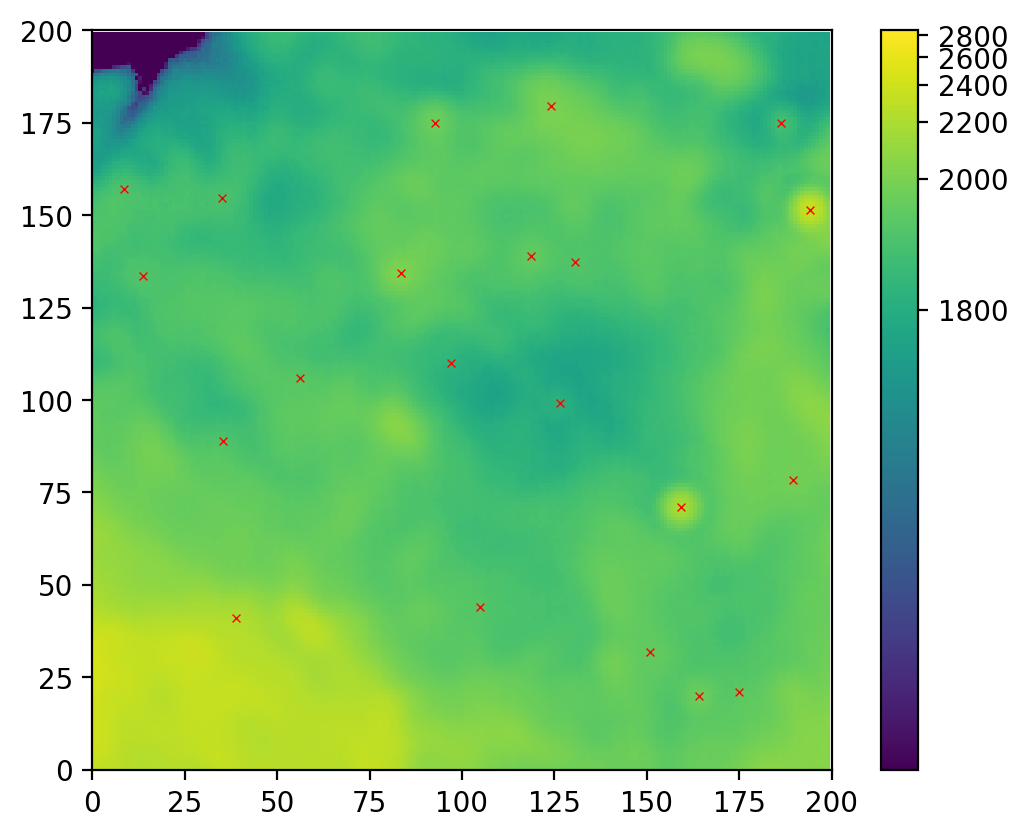

In [97]:
pl.figure(dpi=200)
pl.imshow(data[slc], norm=simple_norm(data, min_percent=1, max_percent=99, stretch='log'))
pl.colorbar();
pl.scatter(result['x_fit']-xl, result['y_fit']-yl, marker='x', color='r', linewidths=0.5, s=8)
pl.axis([0,200,0,200]);

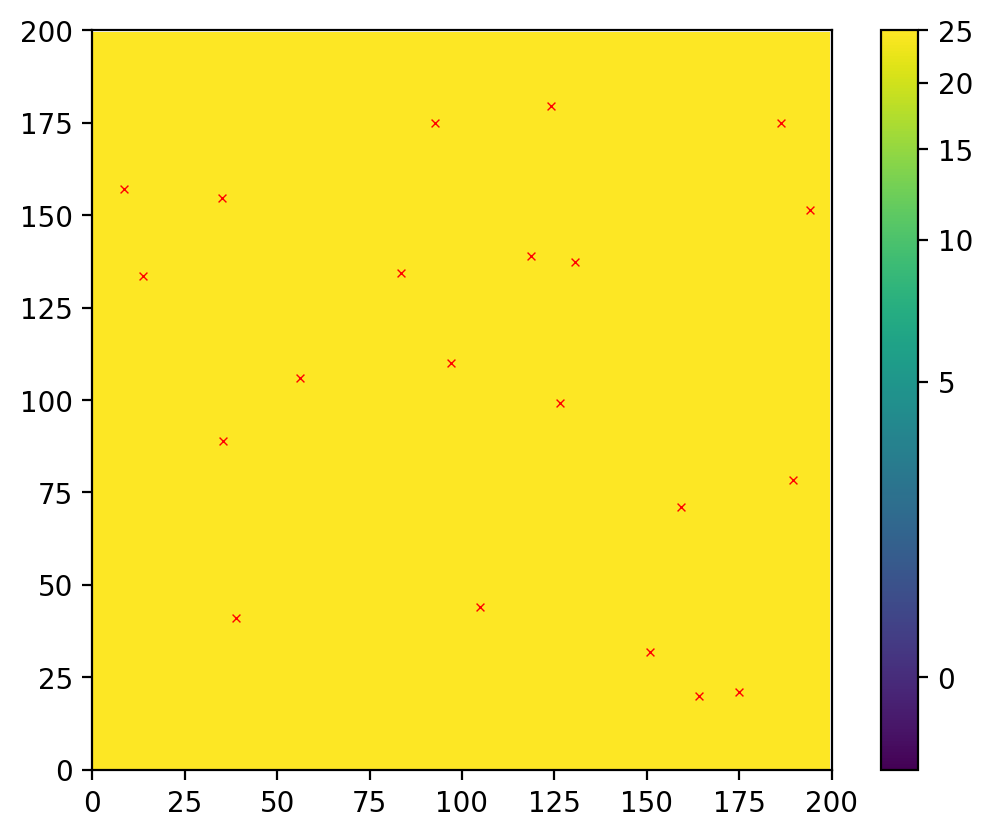

In [98]:
pl.figure(dpi=200)
pl.imshow(residual[slc], norm=simple_norm(residual, min_cut=-1, max_cut=25, stretch='asinh'))
pl.colorbar();
pl.scatter(result['x_fit']-xl, result['y_fit']-yl, marker='x', color='r', linewidths=0.5, s=8)
pl.axis([0,200,0,200]);

# iterative

In [137]:
phot_ = IterativePSFPhotometry(finder=daofind_tuned,
                               localbkg_estimator=LocalBackground(5, 15),
                               psf_model=dao_psf_model,
                               fitter=LevMarLSQFitter(),
                               maxiters=2,
                               fit_shape=(5, 5),
                               sub_shape=(15, 15),
                               aperture_radius=2*fwhm_pix,
                               progress_bar=True,
                               #mode='all',
                               xy_bounds=1,
                              )

In [138]:
print("About to do ITERATIVE photometry....")
try:
    result2 = result_iter = phot_(data, mask=mask)
except Exception as ex:
    print(ex)
    result2 = result_iter = phot_(data)
    
#print(f"Done with ITERATIVE photometry. len(result2)={len(result2)}  dt={time.time() - t0}")
#coords2 = ww.pixel_to_world(result2['x_fit'], result2['y_fit'])

About to do ITERATIVE photometry....


Fit source/group:   0%|          | 0/3205 [00:00<?, ?it/s]

Add model sources:   0%|          | 0/3205 [00:00<?, ?it/s]

Fit source/group:   0%|          | 0/3260 [00:00<?, ?it/s]

Line 1947 = self.fit_results.append(deepcopy(self._psfphot)) is commented out


In [139]:
residual_iter = phot_.make_residual_image(data, (31, 31), include_localbkg=False)

Add model sources:   0%|          | 0/3205 [00:00<?, ?it/s]

In [140]:
model_iter = phot_.make_model_image(data.shape, (31, 31), include_localbkg=False)

Add model sources:   0%|          | 0/3205 [00:00<?, ?it/s]

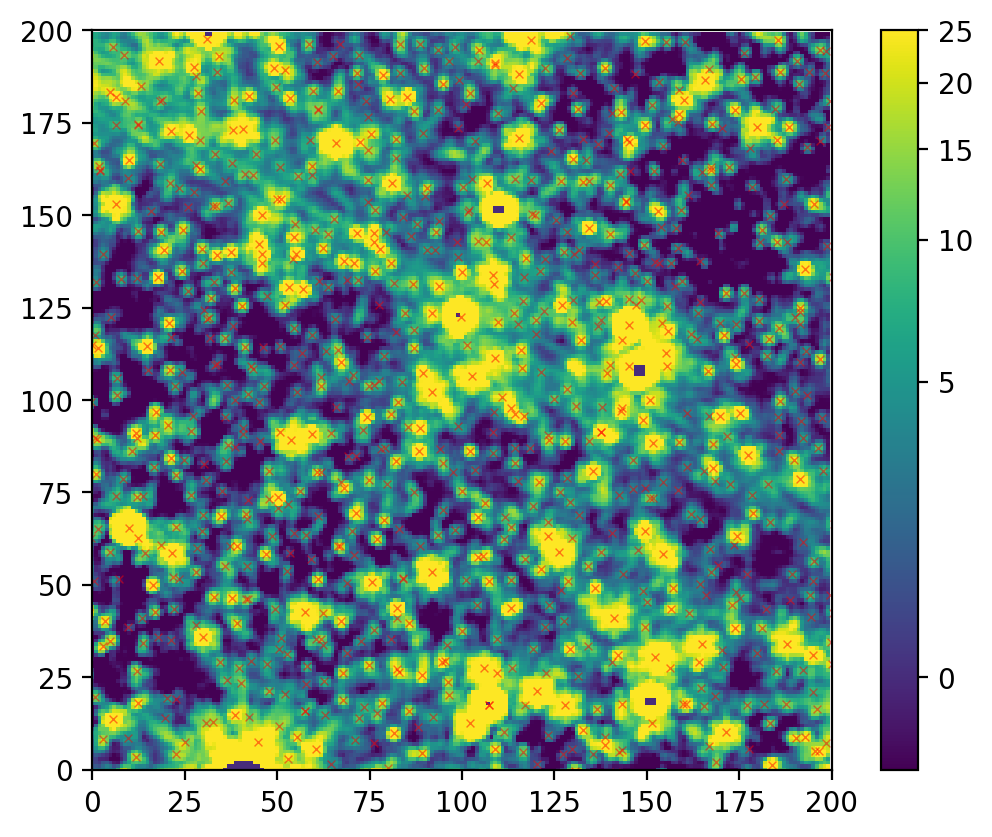

In [141]:
pl.figure(dpi=200)
pl.imshow(data[slc], norm=simple_norm(data, min_cut=-1, max_cut=25, stretch='asinh'))
pl.colorbar();
pl.scatter(result['x_fit']-xl, result['y_fit']-yl, marker='x', color='r', linewidths=0.5, s=8, alpha=0.5)
pl.axis([0,200,0,200]);

In [142]:
pl.figure(dpi=200)
pl.imshow(residual_iter[slc], norm=simple_norm(residual_iter, min_cut=-6, max_cut=25, stretch='asinh'), cmap='gray')
pl.colorbar();
pl.scatter(result['x_fit']-xl, result['y_fit']-yl, marker='x', color='r', linewidths=0.25, s=8)
pl.axis([0,200,0,200]);

# iterative grouped

# Residual zoom

In [127]:
import sys
sys.path.append(f'{basepath}/analysis')
import plot_tools
import importlib as imp
imp.reload(plot_tools)
from plot_tools import diagnostic_stamps_by_mag_dao
def diagnostic_stamps_by_mag(*args, **kwargs):
    return diagnostic_stamps_by_mag_dao(*args, filtername=filtername, pixel_area=ww.celestial.proj_plane_pixel_area(), data=data, **kwargs)

/blue/adamginsburg/adamginsburg/repos/astropy/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


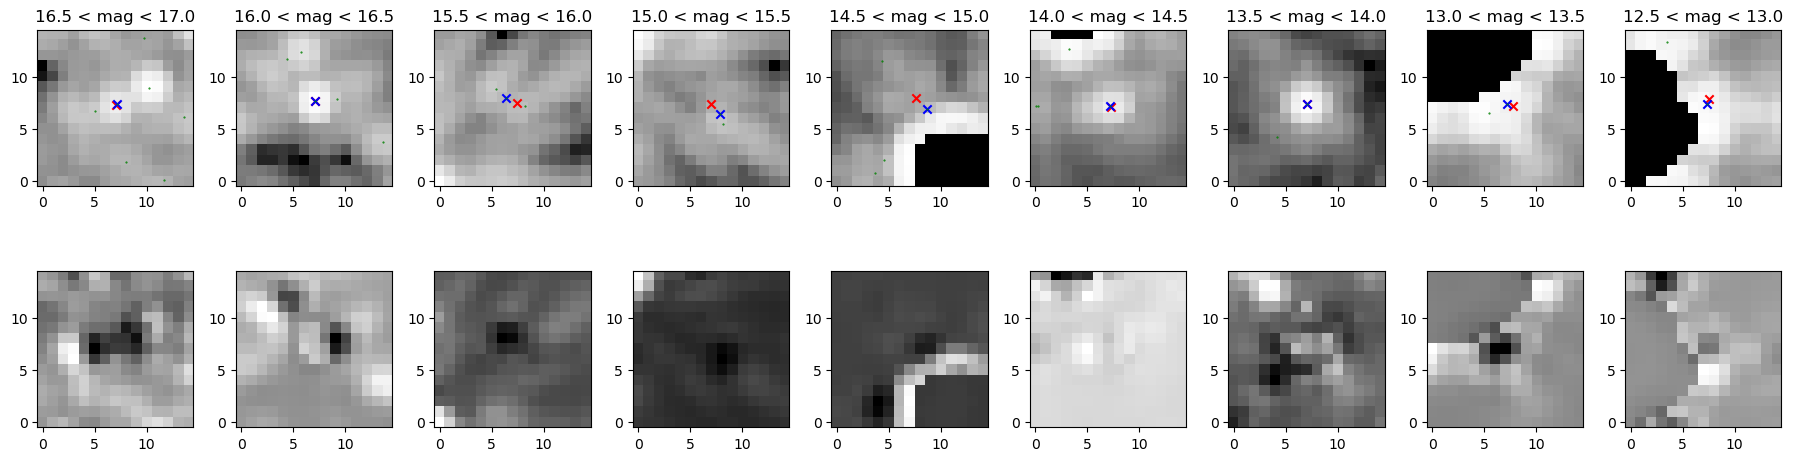

In [128]:
diagnostic_stamps_by_mag(result, residual)

/blue/adamginsburg/adamginsburg/repos/astropy/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


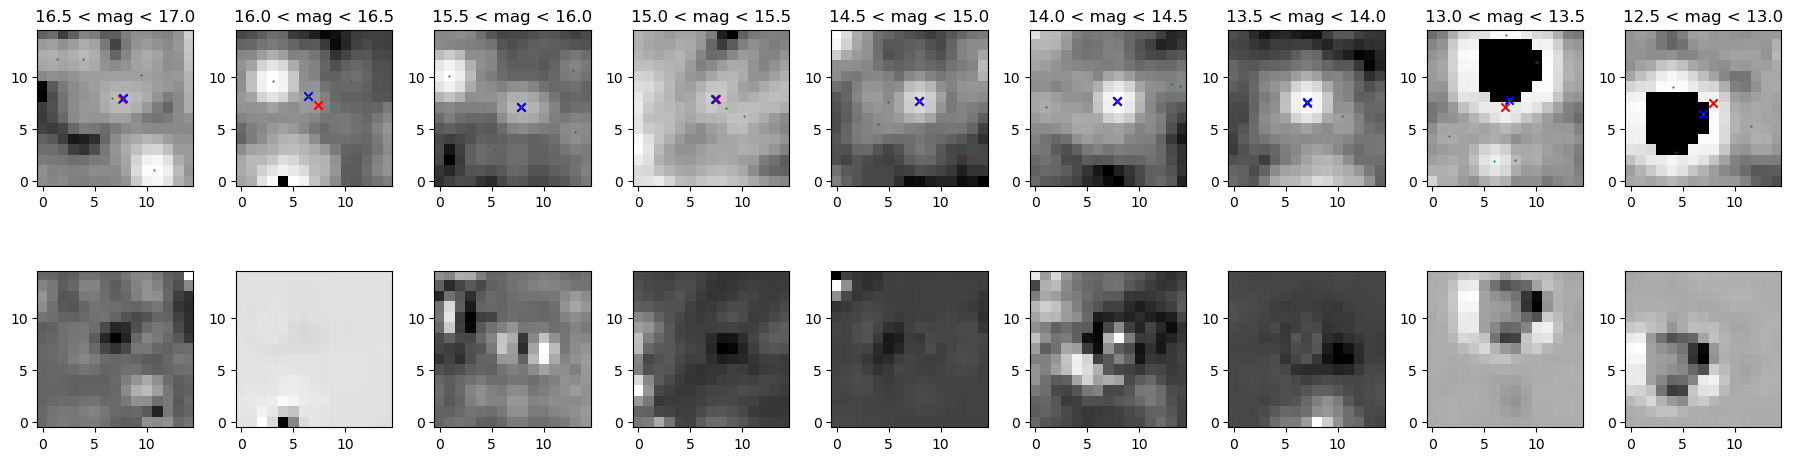

In [129]:
diagnostic_stamps_by_mag(result, residual, ind_offset=1)

/blue/adamginsburg/adamginsburg/repos/astropy/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


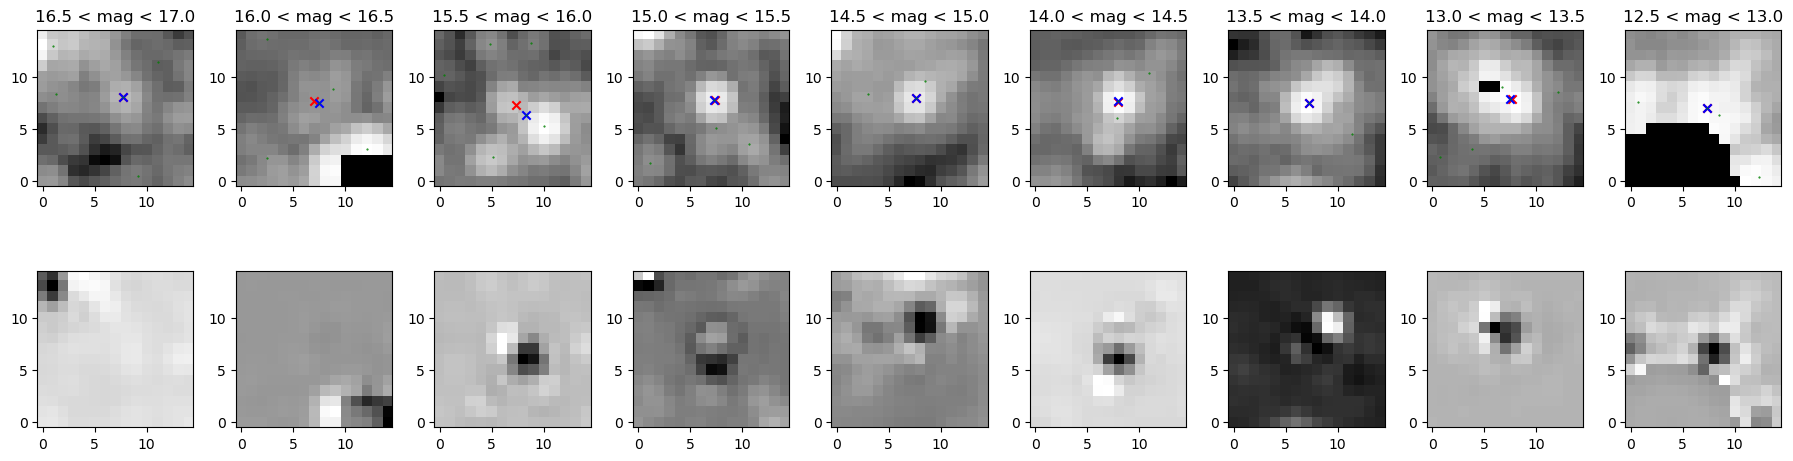

In [130]:
diagnostic_stamps_by_mag(result, residual, ind_offset=2)

/blue/adamginsburg/adamginsburg/repos/astropy/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


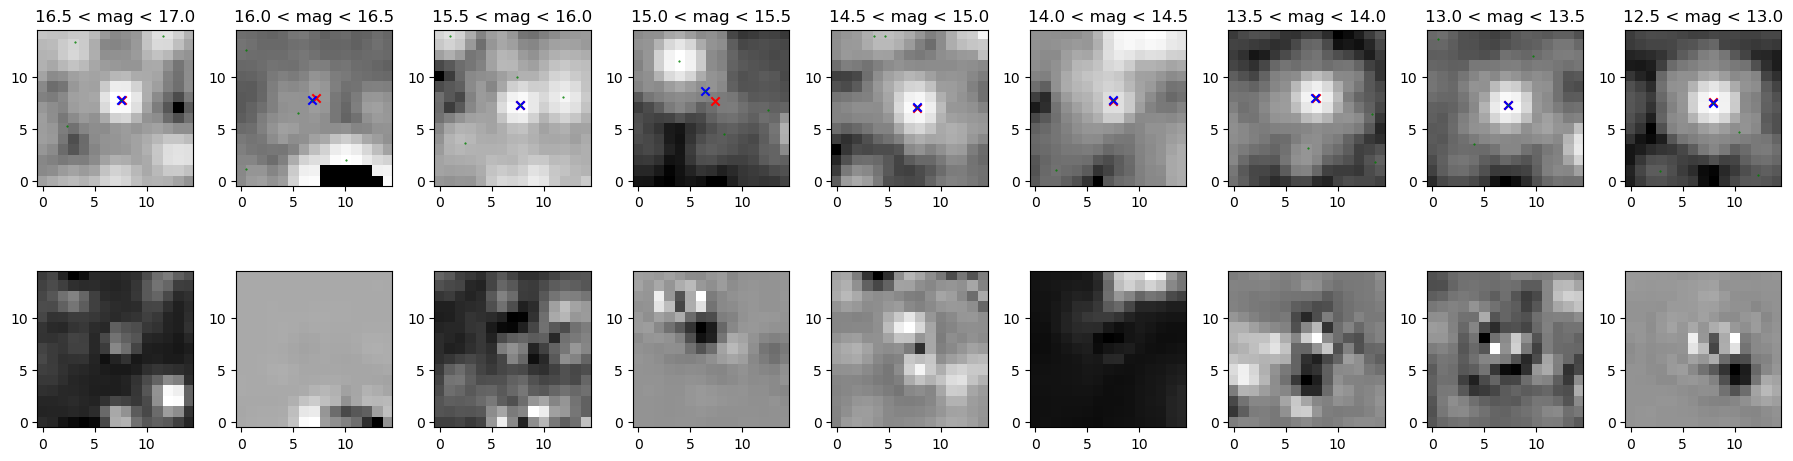

In [131]:
diagnostic_stamps_by_mag(result, residual, ind_offset=3)

/blue/adamginsburg/adamginsburg/repos/astropy/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


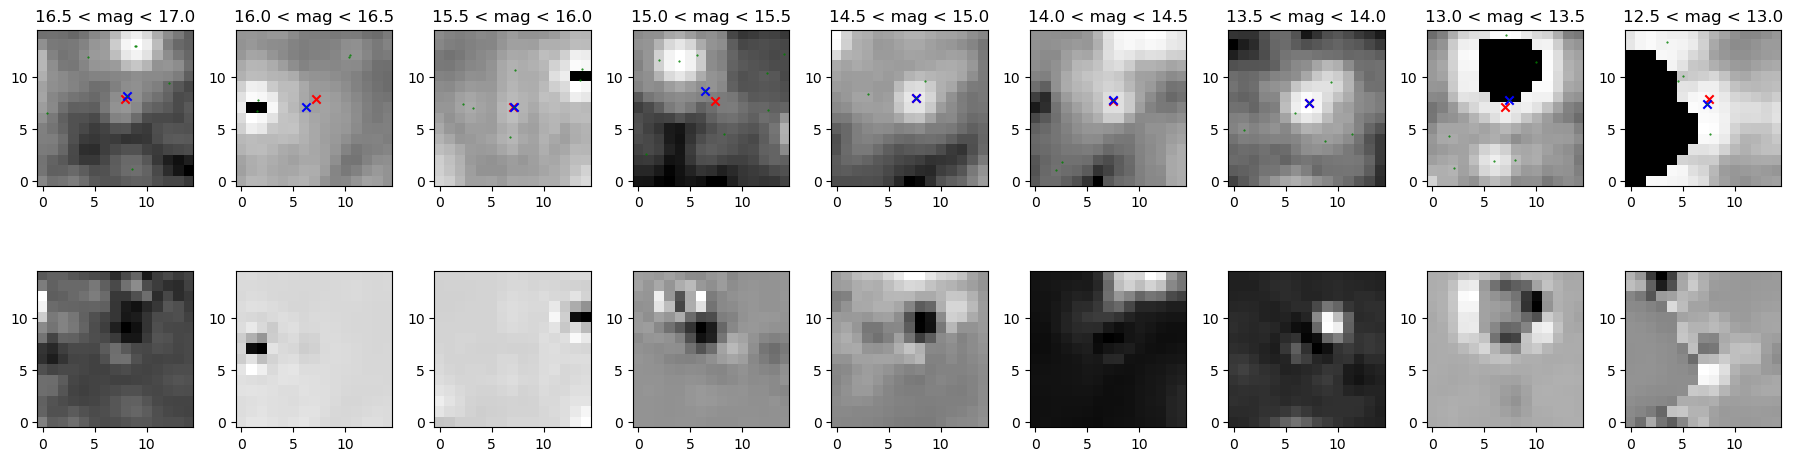

In [132]:
diagnostic_stamps_by_mag(result_iter, residual_iter, ind_offset=0)

/blue/adamginsburg/adamginsburg/repos/astropy/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


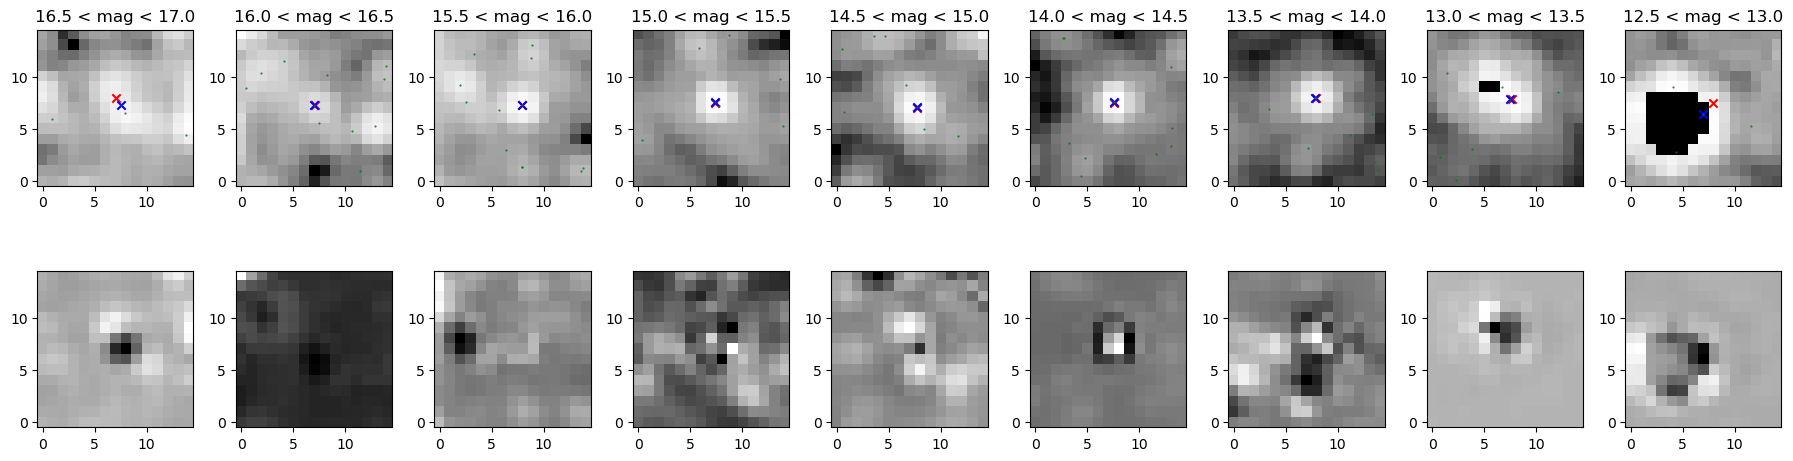

In [133]:
diagnostic_stamps_by_mag(result_iter, residual_iter, ind_offset=1)

In [134]:
diagnostic_stamps_by_mag(result_iter, residual_iter, ind_offset=2)

/blue/adamginsburg/adamginsburg/repos/astropy/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


# Catalog Miri

In [99]:
im1 = fits.open(f'{basepath}/F2550W/pipeline/jw02221-o002_t001_miri_f2550w_i2d.fits')
obsdate = im1[0].header['DATE-OBS']
ww = wcs.WCS(im1[1].header)

module = 'merged'
data = im1['SCI'].data
err = im1['ERR'].data

#im2 = fits.open(f'{basepath}/F2550W/pipeline/jw02221-o002_t001_miri_f2550w_i2d.fits')
#im2['SCI'].data = data
#im2['ERR'].data = err
#for ext in ('CON', 'WHT', 'VAR_POISSON', 'VAR_RNOISE', 'VAR_FLAT'):
#    del im2[ext]
#im2.writeto(f'{basepath}/analysis/MWE_example.fits', overwrite=True)

In [100]:
# crowdsource uses inverse-sigma, not inverse-variance
weight = err**-1
maxweight = np.percentile(weight[np.isfinite(weight)], 95)
minweight = np.percentile(weight[np.isfinite(weight)], 5)
badweight =  np.percentile(weight[np.isfinite(weight)], 1)
weight[err < 1e-5] = 0
#weight[(err == 0) | (wht == 0)] = np.nanmedian(weight)
weight[np.isnan(weight)] = 0
bad = np.isnan(weight) | (data == 0) | np.isnan(data) | (weight == 0) | (err == 0) | (data < 1e-5)

weight[weight > maxweight] = maxweight
weight[weight < minweight] = minweight
# it seems that crowdsource doesn't like zero weights
# may have caused broked f466n? weight[bad] = badweight
weight[bad] = minweight
# crowdsource explicitly handles weight=0, so this _should_ work.
weight[bad] = 0

# Expand bad pixel zones for dq
bad_for_dq = ndimage.binary_dilation(bad, iterations=2)
print(f"Total bad pixels = {bad.sum()}, total bad for dq={bad_for_dq.sum()}")

mask = bad

mask = scipy.ndimage.binary_dilation(scipy.ndimage.binary_erosion(mask, iterations=1), iterations=1)
mask = scipy.ndimage.binary_erosion(scipy.ndimage.binary_dilation(mask, iterations=1), iterations=1)

Total bad pixels = 372527, total bad for dq=428332


In [101]:
daofind_tuned = DAOStarFinder(threshold=5 * filtered_errest,
                              fwhm=fwhm_pix, roundhi=0.3, roundlo=-0.3,
                              sharplo=0.30, sharphi=1.40,
                              exclude_border=True
                             )
print("Finding stars with daofind_tuned", flush=True)
finstars = daofind_tuned(np.nan_to_num(data), mask=mask)

print(f"Found {len(finstars)} with daofind_tuned", flush=True)
# for diagnostic plotting convenience
finstars['x'] = finstars['xcentroid']
finstars['y'] = finstars['ycentroid']

Finding stars with daofind_tuned
Found 1317 with daofind_tuned


In [102]:
phot = PSFPhotometry(finder=daofind_tuned,#finder_maker(),
                     #grouper=grouper,
                     #localbkg_estimator=None, # must be none or it un-saturates pixels
                     localbkg_estimator=LocalBackground(5, 15),
                     psf_model=dao_psf_model[0],
                     fitter=LevMarLSQFitter(),
                     fit_shape=(5, 5),
                     aperture_radius=2*fwhm_pix,
                     progress_bar=True,
                     xy_bounds=1,
                    )

print("About to do BASIC photometry....")
t0 = time.time()

# mask causes the error 'ValueError: For one or more sources, the number of data points available to fit is less than the number of fit parameters. This could be due to a source(s) near the edge of the detector or if it has few unmasked pixels. Please check the input mask or source positions.'
# for f444w.  This is certainly a bug; daofind shouldn't put stars there.
result = phot(np.nan_to_num(data), mask=mask)
print(f"Done with BASIC photometry.  len(result)={len(result)} dt={time.time() - t0}")

About to do BASIC photometry....


Fit source/group:   0%|          | 0/1317 [00:00<?, ?it/s]

Done with BASIC photometry.  len(result)=1317 dt=26.343700408935547


In [103]:
residual = phot.make_residual_image(data, (71, 71), include_localbkg=False)

Add model sources:   0%|          | 0/1317 [00:00<?, ?it/s]

In [104]:
model = phot.make_model_image(data.shape, (71, 71), include_localbkg=False)

Add model sources:   0%|          | 0/1317 [00:00<?, ?it/s]

In [105]:
model_withbg = phot.make_model_image(data.shape, (71, 71), include_localbkg=True)

Add model sources:   0%|          | 0/1317 [00:00<?, ?it/s]

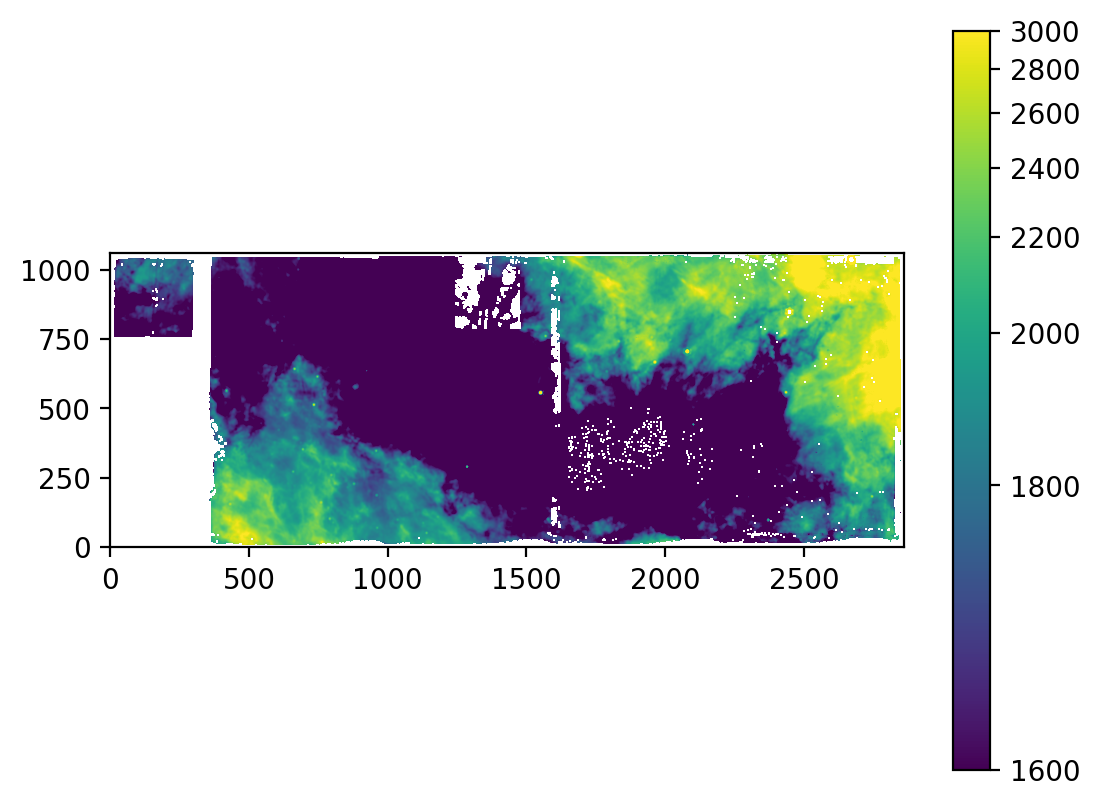

In [106]:
pl.figure(dpi=200)
pl.imshow(data, norm=simple_norm(data, min_cut=1600, max_cut=3000, stretch='asinh'))
pl.colorbar();

In [107]:
pl.figure(dpi=200)
pl.imshow(data, norm=simple_norm(data, min_cut=1600, max_cut=3000, stretch='asinh'), cmap='gray')
pl.colorbar();
s1 = result['flux_fit'] > 5000
pl.scatter((result['x_fit'])[s1], (result['y_fit'])[s1], marker='x', color='red', cmap='jet',
           linewidths=0.5, s=8)
s2 = (result['flux_fit'] < 5000) & (result['flux_fit'] > 1000)
pl.scatter((result['x_fit'])[s2], (result['y_fit'])[s2], marker='x', color='blue', cmap='jet',
           linewidths=0.5, s=8);

/scratch/local/39765574/ipykernel_647341/868644761.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  pl.scatter((result['x_fit'])[s1], (result['y_fit'])[s1], marker='x', color='red', cmap='jet',
/scratch/local/39765574/ipykernel_647341/868644761.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  pl.scatter((result['x_fit'])[s2], (result['y_fit'])[s2], marker='x', color='blue', cmap='jet',


In [108]:
pl.figure(dpi=200)
pl.imshow(residual, norm=simple_norm(residual, min_cut=1500, max_cut=3000, stretch='asinh'))
pl.colorbar();

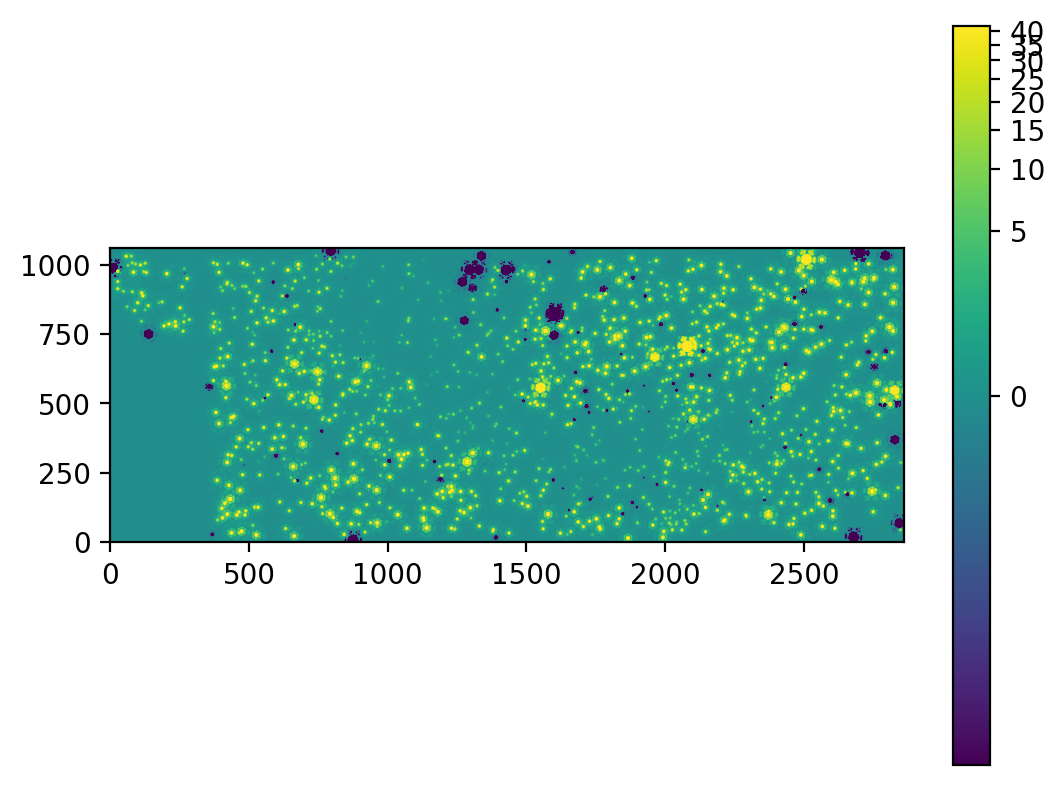

In [109]:
pl.figure(dpi=200)
pl.imshow(model, norm=simple_norm(model, min_percent=1, max_percent=99, stretch='log'))
pl.colorbar();